In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import sys
from scipy.optimize import minimize
from tqdm import tqdm
from common import tool_times
from common import well_construction as wc
from common.sensor_types import sensors
from solvers.solver_cim_py.interface import Solver
import torch
import plotly
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torch
import torch.optim as optim
from model import Net
model = torch.load('model_weights/modelentire.pth')
model.load_state_dict(torch.load('model_weights/model.pth'))
loss_function = nn.MSELoss()
model.eval()

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
net = model.double().to(device)

def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = + 10 ** (-15)) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])
    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt
    
    loss = np.dot(e, e)
    return loss



t = 1e-3 * np.array([
    0.135, 0.180, 0.235, 0.315, 0.365, 0.420,
    0.485, 0.560, 0.650, 0.750, 0.865, 1.000,
    1.155, 1.335, 1.540, 1.780, 2.055, 2.370,
    2.740, 3.160, 3.650, 4.215, 4.870, 5.625,
    6.495, 7.500, 8.660, 10.00, 11.55, 13.34,
    15.40, 17.79, 20.54, 23.72, 27.39, 31.63,
    36.52, 42.17, 48.70, 56.24, 64.94, 74.99,
    86.60, 100.0, 115.5, 133.4
])

df = pd.read_pickle('Dataset')
#fix_normed_vector = df.sample(1) временно
fix_normed_vector = df.loc[9030]
fix_normed_vector = pd.DataFrame(fix_normed_vector).transpose()
print ('Зафиксировали произвольный вектор из датафрейма с компонентами \n')
fix_normed_vector

Зафиксировали произвольный вектор из датафрейма с компонентами 



,Sigma,mu,d,th,th0,Decay
9030,-0.809753,-1.56861,0,-0.248755,0,"[0.17439216402987712, 0.15983478220067351, 0.1..."


## Считаем лосс (сигма, мю) через модельную функцию

### Нахождение границ для оптимизатора с учетом параметров усреднения первоначальной выборки

In [113]:
means = np.fromfile('means_scaler')
#print(means)
stds = np.fromfile('stds_scaler')

real_min_sigma = df.describe()['Sigma']['min'] * stds[0] + means[0]
#print ('real min sigma ', min_sigma)

norm_min_sigma =  df.describe()['Sigma']['min'] 
print ('norm min sigma ',norm_min_sigma )

real_max_sigma = df.describe()['Sigma']['max'] * stds[0] + means[0]
#print ('real max sigma ', max_sigma)

norm_max_sigma = df.describe()['Sigma']['max']
print ('norm max sigma ', norm_max_sigma )

real_min_mu = df.describe()['mu']['min'] * stds[1] + means[1]
#print('real min mu ', min_mu)

norm_min_mu = df.describe()['mu']['min']
print ('norm min mu', norm_min_mu)

real_max_mu = df.describe()['mu']['max'] * stds[1] + means[1]
#print ('real max mu ', max_mu)

norm_max_mu = df.describe()['mu']['max']
print ('norm max mu ', norm_max_mu)

#fix_real_vector = df.sample(1)
fix_real_vector = fix_normed_vector[['Sigma', 'mu', 'd', 'th', 'th0']]
fix_real_vector = fix_real_vector*stds+means
fix_real_vector['Decay'] = fix_normed_vector['Decay']
print ('Зафиксировали произвольный вектор из датафрейма с real компонентами \n')
fix_real_vector

norm min sigma  -1.7384717023084395
norm max sigma  1.7400442193406047
norm min mu -1.73281163150911
norm max mu  1.7310589144531967
Зафиксировали произвольный вектор из датафрейма с real компонентами 



,Sigma,mu,d,th,th0,Decay
9030,3.40287e+06,16.6383,89,5.38955,6.5,"[0.17439216402987712, 0.15983478220067351, 0.1..."


### Подсчет и построение тепловых карт лосса с помощью нейросети и модельной функции

In [66]:
def model_decay(d=fix_real_vector.get('d').iloc[0], th0=fix_real_vector.get('th0').iloc[0],
                th=fix_real_vector.get('th').iloc[0], sigma=fix_real_vector.get('Sigma').iloc[0],
                mu=fix_real_vector.get('mu').iloc[0]):
    tubes = [
        wc.Tube(d=(d), th0=(th0), th=(th), sigma=(sigma), mu=(mu)),
    ]

    sensor = sensors.PULSE_3E_1
    times = tool_times.times[sensor]
    solver = Solver(sensor, times, tool_averaging=True, verbose=0)
    output = solver.get_curve(tubes)
    return(output)

def model_loss(real_sigma,real_mu):
    return np.log(weighted_mse(np.array(fix_real_vector.get('Decay').iloc[0]), np.array(model_decay(sigma=real_sigma,
                                                                             mu=real_mu)),t))
def net_loss(norm_sigma, norm_mu):
    tensor = torch.tensor([fix_normed_vector.get('Sigma').iloc[0],norm_sigma,
                           fix_normed_vector.get('mu').iloc[0],norm_mu,
                           fix_normed_vector.get('th').iloc[0],fix_normed_vector.get('th').iloc[0]])
    tensor = tensor.to(device)
    output = net(tensor.double())
    return (output.item())

def l2_norm(norm_sigma, norm_mu):
     return np.linalg.norm([fix_normed_vector.get('Sigma').iloc[0] - norm_sigma,
                          fix_normed_vector.get('mu').iloc[0] - norm_mu])

def model_minimization_function(variable_vector, constant=0.5):
    real_sigma = variable_vector[0]
    real_mu = variable_vector[1]
    norm_sigma = (real_sigma - means[0]) / stds[0]
    norm_mu = (real_mu - means[1]) / stds[1]
    return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))

#### Вычисление и построение карты model_loss and net_loss 

In [67]:
size = 30
sigma_real = np.linspace(min_sigma, max_sigma, num=size, retstep=True)#sigma
mu_real = np.linspace(min_mu, max_mu, num=size, retstep=True)#mu
i = 0
j = 0
loss_model = np.zeros((size,size))

for i in tqdm(range(size)):
    while (j < size):
        loss_model[i][j] = model_loss(sigma_real[0][j],mu_real[0][i])
        j = j + 1
    j = 0
loss_model = pd.DataFrame(loss_model)
loss_model.index = np.around(mu_real[0],1) 
loss_model.columns = np.around(sigma_real[0],3)
loss_model.to_pickle('./loss_model_model_matrix.pkl')
#loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:16<00:00, 50.56s/it]


In [68]:
#loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

In [69]:
i = 0
j = 0
loss_net = np.zeros((size, size))
sigma_norm = (sigma_real[0] - means[0]) / stds[0] 
mu_norm = (mu_real[0] - means[1]) / stds[1]

for i in tqdm(range(size)):
    while (j < size):
        loss_net[i][j] = net_loss(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
loss_net = pd.DataFrame(loss_net)
loss_net.index = np.around(mu_real[0],1) 
loss_net.columns = np.around(sigma_real[0],3)
loss_net.to_pickle('./loss_net_model_matrix.pkl')
#loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.34it/s]


In [10]:
#loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

#### Разница результатов классического и нейросетевого подхода

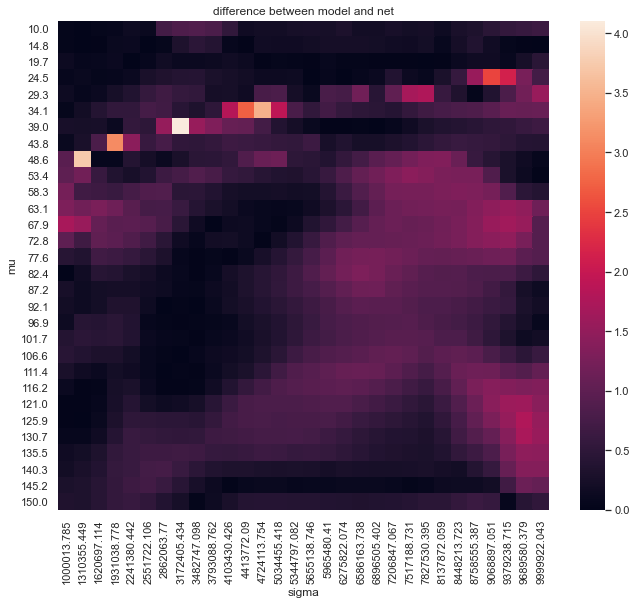

In [85]:
diff = abs(loss_model - loss_net)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(diff, annot=False, vmin=0)
#name = 'log( loss( (' + str(fix_vector.get('mu').iloc[0])+ ', (' + str(fix_vector.get('Sigma').iloc[0]) + ')))'
name = "difference between model and net"
ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle1 = plt.Circle((size/2,size/2), 0.5, color='g', fill=False, label="The zone of the fix vector")
# ax.add_patch(circle1)
# ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Тепловая карта спадов модельных данных и нейросети

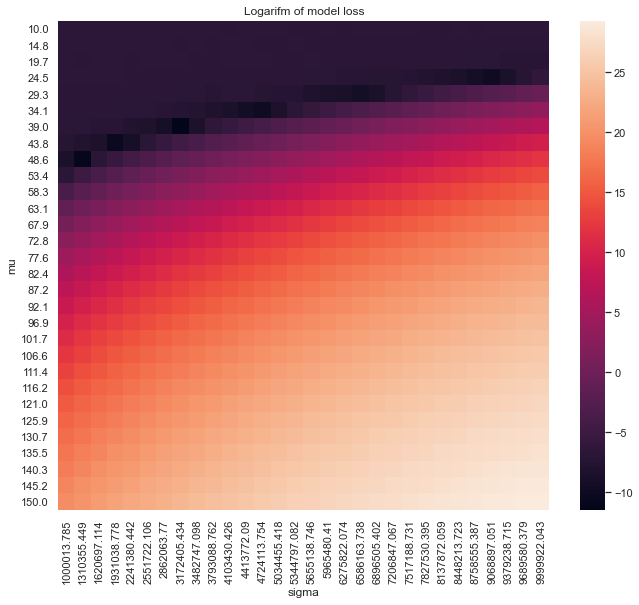

In [86]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(loss_model, annot=False)
name = "Logarifm of model loss"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

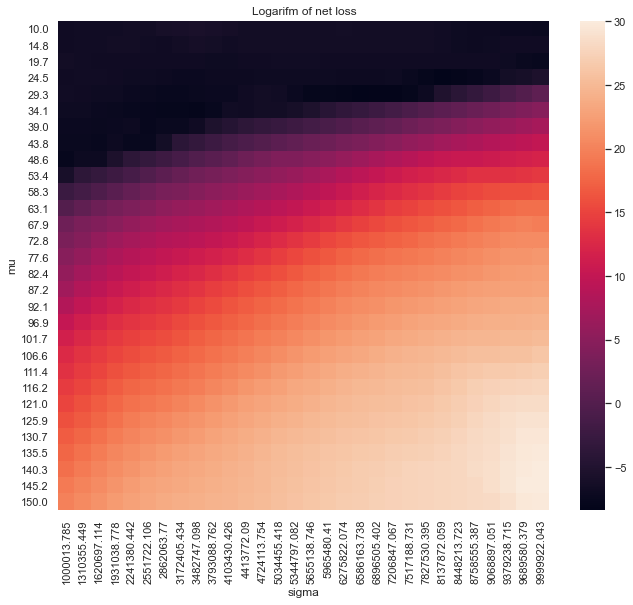

In [87]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(loss_net, annot=False)
name = "Logarifm of net loss"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Подсчет и построение тепловой карты л2 нормы

In [90]:

l2 = np.zeros((size, size))
i = 0
j = 0
for i in tqdm(range(size)):
    while (j < size):
        l2[i][j] = l2_norm(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
l2 = pd.DataFrame(l2)
l2.index = np.around(mu_real[0],1) 
l2.columns = np.around(sigma_real[0],3)
l2.to_pickle('./l2_matrix.pkl')
#l2 = pd.read_pickle('./l2_matrix.pkl')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 791.25it/s]


In [91]:
#l2 = pd.read_pickle('./l2_matrix.pkl')

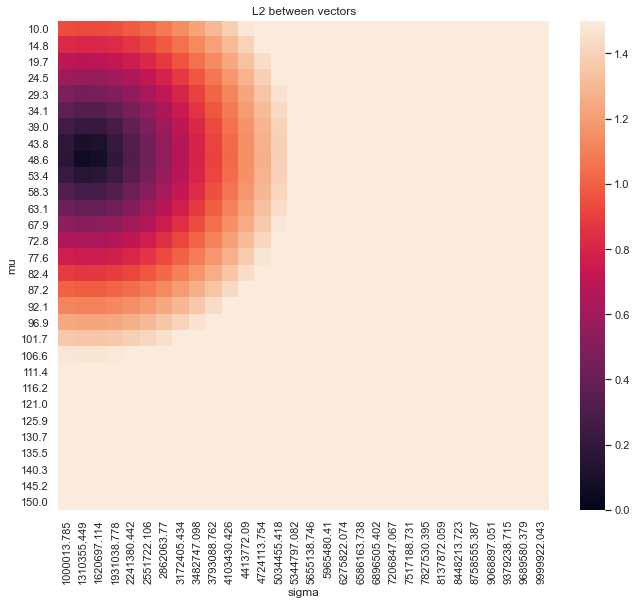

In [92]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(l2, annot=False, vmin=0, vmax=1.5)
name = "L2 between vectors"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Взвешенная сумма -l2_norm + constant * loss_model

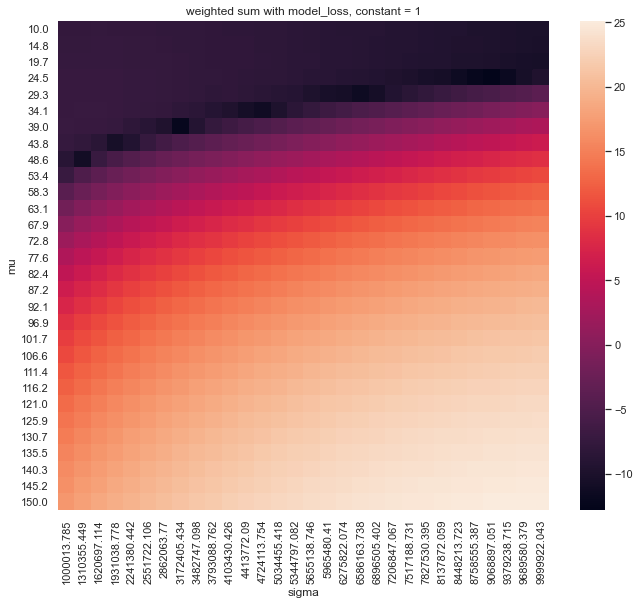

In [132]:
constant = 1
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Оптимизация model_minimization_function

In [94]:
minimize_result_data = []
constant = np.linspace(0.01,1,20)
for const in tqdm(constant):
    def model_minimization_function(variable_vector, constant=const):
        real_sigma = variable_vector[0]
        real_mu = variable_vector[1]
        norm_sigma = (real_sigma - means[0]) / stds[0]
        norm_mu = (real_mu - means[1]) / stds[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
    x0 = np.array([fix_real_vector.get('Sigma').iloc[0],fix_real_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='SLSQP', bounds=((sigma_min[0][0] * stds[0] + means[0], 
                                                                    sigma_max[0][0] * stds[0] + means[0]),
                                                                   (mu_min[0][0] * stds[1] + means[1],
                                                                    mu_max[0][0] * stds[1] + means[1])),options={'disp': False,
                                                                                                                'maxiter':1e6,
                                                                                                                'ftol':1e-9,
                                                                                                                'eps': 0.1})
    minimize_result_data.append({'l2_norm': l2_norm((res.x[0] - means[0]) / stds[0], (res.x[1] - means[1]) / stds[1]),
                                 'log_loss': model_loss(res.x[0], res.x[1]),
                                 'loss': np.exp(model_loss(res.x[0], res.x[1])),
                                 'constant': const, 'data': res.x, 'message': res.message})
minimize_result_data = pd.DataFrame(minimize_result_data)
minimize_result_data
#print(res)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [32:02<00:00, 96.14s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.002116,-13.187717,1.873473e-06,0.010000,"[3402871.5912978346, 16.55276945965613]",Optimization terminated successfully
1,0.004138,-14.846995,3.564776e-07,0.062105,"[3402871.4926308407, 16.471037457726936]",Optimization terminated successfully
2,0.011914,-11.679586,8.464868e-06,0.114211,"[3402870.074729704, 17.119801730432222]",Optimization terminated successfully
3,0.000006,-14.400580,5.570669e-07,0.166316,"[3402871.5383739364, 16.638065048364084]",Optimization terminated successfully
4,0.006229,-13.725056,1.094672e-06,0.218421,"[3402870.8680206463, 16.386540124630635]",Optimization terminated successfully
5,0.000670,-15.730196,1.473882e-07,0.270526,"[3402871.3548710058, 16.611221131084534]",Optimization terminated successfully
6,0.005319,-13.908716,9.110064e-07,0.322632,"[3402871.669080248, 16.423333416237714]",Optimization terminated successfully
7,0.003143,-14.408052,5.529205e-07,0.374737,"[3402871.6203308473, 16.511250753707245]",Optimization terminated successfully
8,0.007739,-12.986092,2.291985e-06,0.426842,"[3402871.4796972987, 16.32551637773554]",Optimization terminated successfully
9,0.000010,-10.268471,3.471042e-05,0.478947,"[3402871.5375862094, 16.637874924408166]",Optimization terminated successfully


#### Оптимизация функции нормированных величин

In [118]:
minimize_result_data = []
constant = np.linspace(0.001,0.2,20)
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='SLSQP', bounds=((norm_min_sigma, norm_max_sigma),
                                                                             (norm_min_mu, norm_max_mu)),options={'disp': False,
                                                                                                                'maxiter':1e6,
                                                                                                                'ftol':1e-9,
                                                                                                                })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_2 = pd.DataFrame(minimize_result_data)
minimize_result_data_2

 10%|████████▎                                                                          | 2/20 [01:25<12:52, 42.90s/it]


KeyboardInterrupt: 

In [ ]:
def callbackF(xk):
    print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
constant = np.linspace(2e-04,5e-04,5)
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='SLSQP',
                    callback=callbackF
                    ,bounds=((norm_min_sigma, norm_max_sigma),
                                                                             (norm_min_mu, norm_max_mu)),options={'disp': False,
                                                                                                                'maxiter':1e6,
                                                                                                                'ftol':1e-9,
                                                                                                                })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_2 = pd.DataFrame(minimize_result_data)
minimize_result_data_2

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

there is xk [1355656.0777273048, 16.02744584420337]
there is xk [1000013.7854460794, 51.19614527886628]
there is xk [3400986.8822237197, 16.638047399079284]
there is xk [3397391.1060532774, 16.68906933303223]
there is xk [3397316.829260164, 16.688804711667203]


 20%|████████████████▌                                                                  | 1/5 [01:41<06:45, 101.43s/it]

there is xk [1311886.0455435878, 15.285778083880743]
there is xk [3769751.910483843, 10.001820859598737]
there is xk [3796159.580151925, 10.001820859598737]
there is xk [3412787.1878257645, 16.43536390979297]
there is xk [3401580.503917034, 16.623603123530607]
there is xk [3401512.505276179, 16.622036887394508]
there is xk [3401579.5885799252, 16.622306395276468]
there is xk [3401586.341028098, 16.623817569695966]
there is xk [3401586.3229463664, 16.623818237918314]


 40%|█████████████████████████████████▏                                                 | 2/5 [04:20<05:55, 118.59s/it]

there is xk [2135734.632905275, 29.24409945121605]


In [142]:
def callbackF(xk):
    print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
constant = np.linspace(1e-5,1e-03,5)
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='L-BFGS-B', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False,
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_3 = pd.DataFrame(minimize_result_data)
minimize_result_data_3

 20%|████████████████▌                                                                  | 1/5 [02:16<09:05, 136.36s/it]


KeyboardInterrupt: 